## Advanced Lane Finding Project

In this project, my goal is to write a software pipeline to identify the lane boundaries in a video.


The goals / steps of this project are the following:

+ Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
+ Apply a distortion correction to raw images.
+ Use color transforms, gradients, etc., to create a thresholded binary image.
+ Apply a perspective transform to rectify binary image ("birds-eye view").
+ Detect lane pixels and fit to find the lane boundary.
+ Determine the curvature of the lane and vehicle position with respect to center.
+ Warp the detected lane boundaries back onto the original image.
+ Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing the pipeline on single frames.

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The two main OpenCV functions used for image calibration are `findChessboardCorners` and `calibrateCamera`. I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. 

The initial repository contained several images of a chessboard taken from different angles with the same camera. This initial set of images is the input to `findChessboardCorners` which outputs object points and image coordinates corresponding to the location of the corners of the internal chessboard. `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection. These are appended to the `imgpoints` and `objpoints` arrays respectively. 

These arrays are fed into the `calibrateCamera` function which returns camera calibration and distortion coefficients. As a result, the OpenCV `undistort` function undo's the effects of distortion on any image produced by the same camera as see below. Please also note the corners drawn onto the chessboard images using `drawChessboardCorners` function below.

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from tracker import Tracker
from utils import *
%matplotlib inline

In [2]:
dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print("working on", fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = "corners_found" + str(idx) + ".jpg"
        cv2.waitKey(500)
        cv2.imwrite(write_name,img)

img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration_pickle.p", "wb"))

working on camera_cal/calibration10.jpg
working on camera_cal/calibration11.jpg
working on camera_cal/calibration12.jpg
working on camera_cal/calibration13.jpg
working on camera_cal/calibration14.jpg
working on camera_cal/calibration15.jpg
working on camera_cal/calibration16.jpg
working on camera_cal/calibration17.jpg
working on camera_cal/calibration18.jpg
working on camera_cal/calibration19.jpg
working on camera_cal/calibration2.jpg
working on camera_cal/calibration20.jpg
working on camera_cal/calibration3.jpg
working on camera_cal/calibration6.jpg
working on camera_cal/calibration7.jpg
working on camera_cal/calibration8.jpg
working on camera_cal/calibration9.jpg


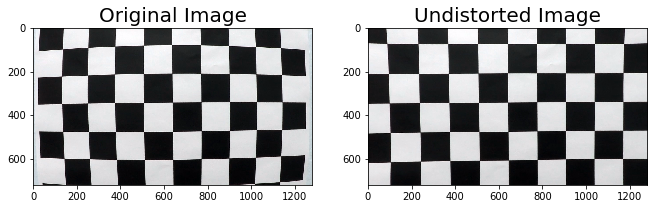

In [4]:
# Visualize undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

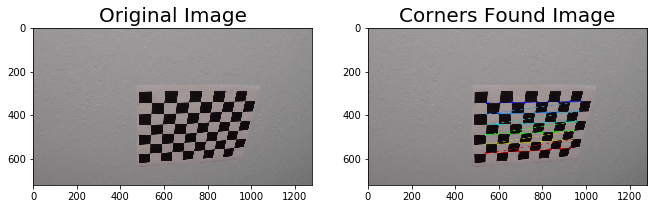

In [5]:
img1 = cv2.imread("camera_cal/calibration10.jpg")
img2 = cv2.imread("output_images/corners_found1.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Corners Found Image', fontsize=20)

### 1. Provide an example of a distortion-corrected image.

Notice the distortion-corrected image contains a partial image for the white vehicle, corrections are more visible on the image edges.

In [6]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    result = img
    write_name = "output_images/distortion_corrected" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

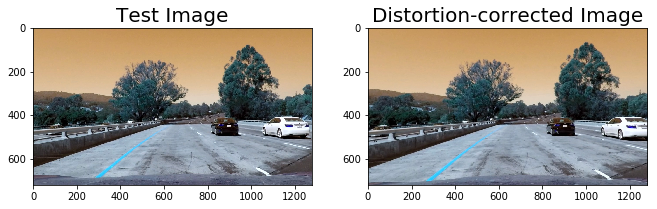

In [7]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/distortion_corrected0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Distortion-corrected Image', fontsize=20)

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [8]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    result = preprocessImage
    write_name = "output_images/binary_corrected" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

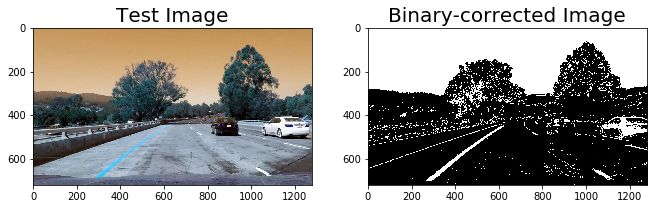

In [9]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/binary_corrected0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Binary-corrected Image', fontsize=20)

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In [10]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    # work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .1 # percent of middle trapizoid height
    height_pct = .63 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.33
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    result = warped
    write_name = "output_images/perspective_transform_corrected" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

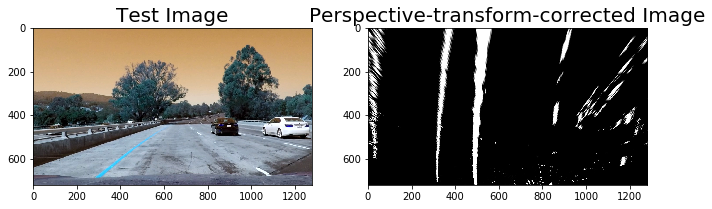

In [11]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/perspective_transform_corrected0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Perspective-transform-corrected Image', fontsize=20)

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [12]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    # work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .1 # percent of middle trapizoid height
    height_pct = .63 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.33
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    # Set up the overall class to do all the tracking
    curve_centers = Tracker(Mymargin = 25, Mycenter_dis = .275*1280, Mywindow_width = 25, Mywindow_height = 40, Mypadding = 25, Myslide_res = 5, Myframe_ps = 1, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    # find the best line centers based on the binary pixel of interest input
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # need these parameters to draw the graphic overlay illustraing the window convolution matching
    window_width = curve_centers.window_width 
    window_height = curve_centers.window_height
    # points used for graphic overlay 
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # points used to find the left and right lanes
    rightx = []
    leftx = []
    
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

        # fill in graphic points here if pixels fit inside the specificed window from l/r mask
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,zero_channel,template)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    write_name = "output_images/lane_line_corrected" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

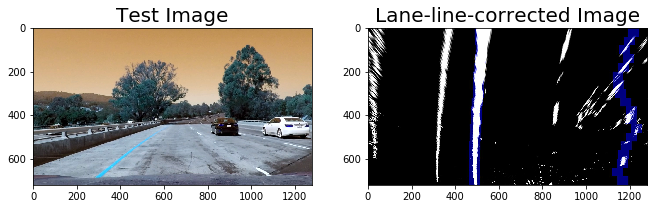

In [21]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/lane_line_corrected0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Lane-line-corrected Image', fontsize=20)

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [41]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    # work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .08 # percent of middle trapizoid height
    height_pct = .62 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
        
    # Set up the overall class to do all the tracking
    curve_centers = Tracker(Mymargin = 25, Mycenter_dis = .275*1280, Mywindow_width = 25, Mywindow_height = 40, Mypadding = 25, Myslide_res = 5, Myframe_ps = 1, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # need these parameters to draw the graphic overlay illustraing the window convolution matching
    window_width = curve_centers.window_width 
    window_height = curve_centers.window_height
    # points used for graphic overlay 
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # points used to find the left and right lanes
    rightx = []
    leftx = []
    
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # add center value found in frame to the list of lane points per left,right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # fill in graphic points here if pixels fit inside the specificed window from l/r mask
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,zero_channel,template)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    # fit the lane boundaries to the left,right center positions found
    yvals = range(0,warped.shape[0])
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    # used to format everything so its ready for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(template)
    road_bkg = np.zeros_like(template)
    cv2.fillPoly(road,[left_lane],color=[255, 0, 0])
    cv2.fillPoly(road,[right_lane],color=[0, 0, 255])  
    
    result = road
   
    write_name = "output_images/lane_identified" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

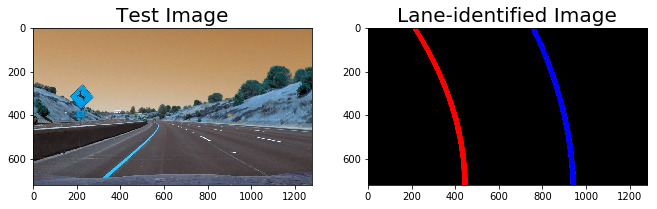

In [43]:
img1 = cv2.imread("test_images/test2.jpg")
img2 = cv2.imread("output_images/lane_identified1.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Lane-identified Image', fontsize=20)

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [48]:
images = glob.glob("test_images/test*.jpg")
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    # work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .08 # percent of middle trapizoid height
    height_pct = .62 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
        
    # Set up the overall class to do all the tracking
    curve_centers = Tracker(Mymargin = 25, Mycenter_dis = .275*1280, Mywindow_width = 25, Mywindow_height = 40, Mypadding = 25, Myslide_res = 5, Myframe_ps = 1, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    # find the best line centers based on the binary pixel of interest input
#     frame_centers = curve_centers.track_line(warped)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # need these parameters to draw the graphic overlay illustraing the window convolution matching
    window_width = curve_centers.window_width 
    window_height = curve_centers.window_height
    # points used for graphic overlay 
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # points used to find the left and right lanes
    rightx = []
    leftx = []
    
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # add center value found in frame to the list of lane points per left,right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # fill in graphic points here if pixels fit inside the specificed window from l/r mask
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,zero_channel,template)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    # fit the lane boundaries to the left,right center positions found
    yvals = range(0,warped.shape[0])
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    # used to format everything so its ready for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(template)
    road_bkg = np.zeros_like(template)
    cv2.fillPoly(road,[left_lane],color=[255, 0, 0])
    cv2.fillPoly(road,[right_lane],color=[0, 0, 255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255, 255, 255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255, 255, 255])    
    
    # after done drawing all the marking effects, warp back image to its orginal perspective.
    # Note for the two different overlays, just seperating road_warped and road_warped_bkg to get two different alpha values, its just for astetics...
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)    
   
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    # calcuate the middle line curvature
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meteres per pixel in x dimension
    
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])

    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    # draw the text showing curvature, offset, and speed
    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(5, 176, 249),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(5, 176, 249),2)

    write_name = "output_images/image_tracked" + str(idx) + ".jpg"
    cv2.imwrite(write_name, result)

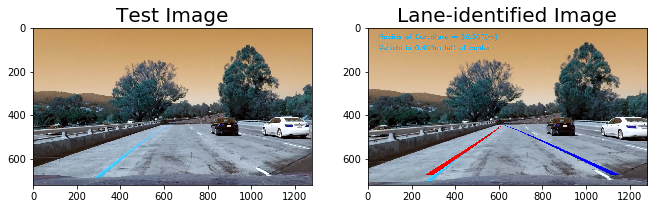

In [49]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/image_tracked0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Test Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Lane-identified Image', fontsize=20)

## Video Pipeline

In [14]:
Selected_Video = 1

if Selected_Video == 1:
    # set up thresholding for the appropriate video to get best pixels of interest
    # For these videos we are focusing on using x/y gradients and hsv and hls color spaces, which seemed most useful for finding important pixels
    gradx_thresh = (25,255) # gradient x threshold
    grady_thresh = (10,255) # gradient y threshold
    schannel_thresh = (100,255) # gradient s channel threshold
    vchannel_thresh = (200,255) # gradient v channel threshold

    # preset percentages to transform road image, want road lines to be as parallel as possible for LineTracker
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .1 # percent of middle trapizoid height
    height_pct = .62 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    
    # Set up the overall class to do all the tracking
    curve_centers = Tracker(Mymargin = 25, Mycenter_dis = .25*1280, Mywindow_width = 25, Mywindow_height = 40, Mypadding = 25, Myslide_res = 5, Myframe_ps = 25, Mycapture_height = 720, \
                                My_ym = 30/720, My_xm = 4/384, Myline_dist = 10)

    # set output and input video names
    Output_video = 'output1_tracked.mp4'
    Input_video = 'project_video.mp4'

In [15]:
def process_image(img):

    # undistort the image 
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient="x", thresh=(12,255) )
    grady = abs_sobel_thresh(img, orient="y", thresh=(25,255) )
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    # work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)
        
    # Set up the overall class to do all the tracking
    curve_centers = Tracker(Mymargin = 25, Mycenter_dis = .275*1280, Mywindow_width = 25, Mywindow_height = 40, Mypadding = 25, Myslide_res = 5, Myframe_ps = 1, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    # find the best line centers based on the binary pixel of interest input
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # need these parameters to draw the graphic overlay illustraing the window convolution matching
    window_width = curve_centers.window_width 
    window_height = curve_centers.window_height
    # points used for graphic overlay 
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # points used to find the left and right lanes
    rightx = []
    leftx = []
    
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # add center value found in frame to the list of lane points per left,right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # fill in graphic points here if pixels fit inside the specificed window from l/r mask
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points+l_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,zero_channel,template)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    graphic_measure = cv2.addWeighted(warpage, 0.2, template, 0.75, 0.0)

    # fit the lane boundaries to the left,right center positions found
    yvals = range(0,warped.shape[0])
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)

    # used to format everything so its ready for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(template)
    road_bkg = np.zeros_like(template)
    cv2.fillPoly(road,[left_lane],color=[255, 0, 0])
    cv2.fillPoly(road,[right_lane],color=[0, 0, 255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255, 255, 255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255, 255, 255])    
    for horz_line_y in curve_centers.horz_lines:
        cv2.line(road,(left_fitx[(int)(horz_line_y)],(int)(horz_line_y)),(right_fitx[(int)(horz_line_y)],(int)(horz_line_y)),color=[5, 176, 249], thickness=3)
    cv2.fillPoly(road_bkg,[inner_lane],color=[38, 133, 197])
    
    # after done drawing all the marking effects, warp back image to its orginal perspective.
    # Note for the two different overlays, just seperating road_warped and road_warped_bkg to get two different alpha values, its just for astetics...
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)    
   
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    # calcuate the middle line curvature
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meteres per pixel in x dimension
    
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])

    # calculate the speed of the car
    speed = curve_centers.CalculateSpeed(metric_mode = False)
    
    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # add text backdrop
    txt_bkg = np.zeros_like(result)
    txt_bkg_pts = np.array([(0,0),((int)(result.shape[1]*.5),0),((int)(result.shape[1]*.5),(int)(result.shape[0]*.25)),(0,(int)(result.shape[0]*.25))])
    cv2.fillPoly(txt_bkg,[txt_bkg_pts],color=[200, 200, 200])
    result = cv2.addWeighted(result, 1.0, txt_bkg, -1.0, 0.0)
    
    # draw the text showing curvature, offset, and speed
    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(5, 176, 249),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(5, 176, 249),2)
    cv2.putText(result,'Estimated Speed is '+str(abs(round(speed,3)))+' MPH',(50,150) , cv2.FONT_HERSHEY_SIMPLEX, 1,(5, 176, 249),2)

    # insert graphic overlay map
    graphic_bkg = np.zeros_like(result)
    # scale the graphic measure that we generated near the start for finding window centers, by some constant factor in both axis
    g_scale = 0.4
    graphic_overlay = cv2.resize(graphic_measure, (0,0), fx=g_scale, fy=g_scale) 
    g_xoffset = result.shape[1]-graphic_overlay.shape[1]
    # overlay the graphic measure in the result image at the top right corner
    result[:graphic_overlay.shape[0], g_xoffset:g_xoffset+graphic_overlay.shape[1]] = graphic_overlay
    
    return result

video_output = Output_video
clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████▉| 1260/1261 [05:10<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 



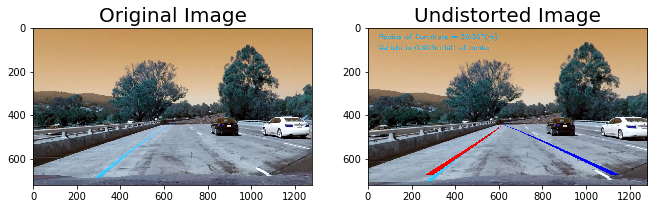

In [16]:
img1 = cv2.imread("test_images/test1.jpg")
img2 = cv2.imread("output_images/tracked0.jpg")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img2)
ax2.set_title('Undistorted Image', fontsize=20)

Here's a [link](https://youtu.be/yKPQqk_v3zc) to the video

In [17]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))